<a href="https://colab.research.google.com/github/LeelaParhyar/Classification-of-Spam-Emails/blob/main/AI%20and%20finace%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Setup & Data Collection

1.1 Install Required Packages

In [1]:
!pip install yfinance pandas numpy matplotlib scipy

1.2 Import Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline


1.3 Download Data & Prepare Returns

In [4]:
# Select financial assets and date range
tickers = ['AAPL', 'MSFT']  # You can change these tickers
start_date = '2010-01-01'
end_date = '2025-05-27'

# Download adjusted close prices
data = yf.download(tickers, start=start_date, end=end_date)

# Check if data is downloaded properly
if data.empty:
    raise ValueError("No data downloaded. Please check tickers and internet connection.")

# Extract Adjusted Close
adj_close = data['Adj Close'] if 'Adj Close' in data else data

# Drop rows with missing values
adj_close.dropna(inplace=True)

# Compute daily simple returns
returns = adj_close.pct_change().dropna()

# Split data into training and test sets
train_returns = returns.loc['2010-01-01':'2023-12-31']
test_returns = returns.loc['2024-01-01':]

# Display sample
train_returns.head()


[*********************100%***********************]  2 of 2 completed


Price          Close                    High                     Low  \
Ticker          AAPL      MSFT          AAPL          MSFT      AAPL   
Date                                                                   
2010-01-05  0.001729  0.000323  5.081716e-03  1.380138e-07  0.004096   
2010-01-06 -0.015907 -0.006137 -1.670112e-03 -6.431769e-04 -0.011724   
2010-01-07 -0.001848 -0.010400 -1.500698e-02 -1.222638e-02 -0.008066   
2010-01-08  0.006648  0.006897  1.641701e-07  5.863287e-03  0.000048   
2010-01-11 -0.008821 -0.012720  4.717056e-03 -3.886225e-03 -0.002918   

Price                     Open              Volume            
Ticker          MSFT      AAPL      MSFT      AAPL      MSFT  
Date                                                          
2010-01-05  0.001635  0.005482  0.007512  0.219098  0.295256  
2010-01-06 -0.003916 -0.001025  0.000972 -0.082646  0.169505  
2010-01-07 -0.010812 -0.012268 -0.008096 -0.135882 -0.131014  
2010-01-08  0.001656 -0.006848 -0.011427 -0.061871  0.012613  
2010-01-11 -0.003968  0.011888  0.014200  0.032660  0.342933

Step 2: Markowitz Portfolio Construction

2.1 Compute Dynamic Covariance Matrices with EWMA

In [5]:
def ewma_covariance_matrix(returns, lambda_=0.94):
    cov_matrices = []
    cov = returns.cov().values  # Initialize covariance matrix
    for t in range(len(returns)):
        r = returns.iloc[t].values.reshape(-1, 1)
        cov = lambda_ * cov + (1 - lambda_) * (r @ r.T)
        cov_matrices.append(cov)
    return cov_matrices

train_covs = ewma_covariance_matrix(train_returns)
print(f"Computed {len(train_covs)} dynamic covariance matrices for training data.")


Computed 3521 dynamic covariance matrices for training data.


2.2 Calculate Daily Minimum Variance Portfolio Weights

In [7]:
# Sanity check: how many assets?
n_assets = train_returns.shape[1]
weights = []

# Calculate weights for each dynamic covariance matrix
for i, cov in enumerate(train_covs):
    try:
        # Compute inverse covariance
        inv_cov = np.linalg.inv(cov)
        ones = np.ones((n_assets, 1))

        # Minimum variance weights: w = Σ⁻¹1 / (1ᵗΣ⁻¹1)
        w = inv_cov @ ones
        w /= ones.T @ inv_cov @ ones

        weights.append(w.flatten())
    except np.linalg.LinAlgError:
        print(f"Skipped day {i} due to singular matrix")
        weights.append(np.full(n_assets, 1/n_assets))  # fallback: equally weighted

# Show first few weights
for i in range(5):
    print(f"Day {i+1}: {weights[i]}")


Day 1: [ 0.0539938   0.132463    0.28802318  0.21588791  0.01743099  0.12027265
 -0.00611084  0.17644874  0.00056984  0.00102074]
Day 2: [ 3.26722217e-02  1.42503801e-01  3.21273680e-01  2.04769908e-01
  6.42921421e-03  1.22240127e-01 -1.16373508e-02  1.80450856e-01
 -3.64198642e-06  1.30118374e-03]
Day 3: [ 1.51513839e-01  9.68611107e-02  1.88343808e-01  2.29440879e-01
 -1.56237565e-02  1.00953051e-01  2.89202156e-02  2.18514701e-01
  1.83558585e-04  8.92592878e-04]
Day 4: [ 1.49397721e-01  1.00782955e-01  1.89940537e-01  2.23169832e-01
 -1.45755752e-02  9.75556595e-02  2.79704041e-02  2.24677926e-01
  1.89543234e-04  8.90996989e-04]
Day 5: [ 0.1504191   0.09942762  0.18447131  0.23183883 -0.01051081  0.09864654
  0.02762993  0.21701722  0.00033198  0.00072827]


2.3 Compute Portfolio Values and Rebalancing Quantities (Simplified Example)

In [8]:
initial_capital = 1000000  # 1 million dollars
portfolio_values = [initial_capital]
positions = [weights[0] * initial_capital / train_returns.iloc[0].values]  # Initial quantity of shares

for t in range(1, len(train_returns)):
    # Calculate portfolio value at day t-1
    prices = data.loc[train_returns.index[t]].values
    portfolio_value = np.sum(positions[-1] * prices)
    portfolio_values.append(portfolio_value)

    # Calculate new positions according to weights and portfolio value
    new_positions = weights[t] * portfolio_value / prices

    positions.append(new_positions)

print(f"Portfolio value on first training day: {portfolio_values[0]:.2f}")
print(f"Portfolio value on last training day: {portfolio_values[-1]:.2f}")


Portfolio value on first training day: 1000000.00
Portfolio value on last training day: 1649688513750219.75


Step 3: Stress Testing Framework


3.1 Compute Daily VaR and Expected Shortfall under Normal Conditions

In [9]:
VaR_list = []
ES_list = []

for i in range(len(train_returns)):
    mu = np.dot(weights[i], train_returns.iloc[i])
    sigma = np.sqrt(weights[i].T @ train_returns.cov().values @ weights[i])
    VaR = norm.ppf(0.05, mu, sigma)
    ES = mu - sigma * norm.pdf(norm.ppf(0.05)) / 0.05
    VaR_list.append(VaR)
    ES_list.append(ES)

print(f"Sample VaR and ES on first training day: VaR={VaR_list[0]:.5f}, ES={ES_list[0]:.5f}")


Sample VaR and ES on first training day: VaR=-0.01570, ES=-0.02060



3.2 (Optional) Implement a Simple Stress Scenario: Volatility Spike

In [10]:
stress_factor = 3  # Triple volatility during stress

stress_VaR = []
stress_ES = []

for i in range(len(train_returns)):
    mu = np.dot(weights[i], train_returns.iloc[i])
    sigma = np.sqrt(weights[i].T @ train_returns.cov().values @ weights[i])
    sigma_stress = sigma * stress_factor
    VaR_s = norm.ppf(0.05, mu, sigma_stress)
    ES_s = mu - sigma_stress * norm.pdf(norm.ppf(0.05)) / 0.05
    stress_VaR.append(VaR_s)
    stress_ES.append(ES_s)

print(f"Stress VaR on first training day: {stress_VaR[0]:.5f}")


Stress VaR on first training day: -0.05427


Step 4: Model Evaluation and Backtesting

4.1 Backtest VaR and ES on Test Set

In [12]:
from scipy.stats import norm

rolling_window = 250  # One year of trading days
test_dates = test_returns.index[rolling_window:]

test_VaR = []
test_ES = []
test_weights = []

for t in range(rolling_window, len(test_returns)):
    try:
        # Get rolling window of past returns
        r_window = test_returns.iloc[t - rolling_window:t]
        cov = r_window.cov().values
        mu = r_window.mean().values
        n_assets = len(mu)

        # Compute min-variance weights
        inv_cov = np.linalg.inv(cov)
        ones = np.ones((n_assets, 1))
        w = inv_cov @ ones
        w /= ones.T @ inv_cov @ ones
        w = w.flatten()

        # Save weights for later if needed
        test_weights.append(w)

        # Compute portfolio mean and std dev
        port_mu = np.dot(w, mu)
        port_sigma = np.sqrt(w.T @ cov @ w)

        # Compute 95% VaR and ES under normal assumption
        VaR = norm.ppf(0.05, loc=port_mu, scale=port_sigma)
        ES = port_mu - port_sigma * norm.pdf(norm.ppf(0.05)) / 0.05

        test_VaR.append(VaR)
        test_ES.append(ES)

    except np.linalg.LinAlgError:
        print(f"Day {t}: Covariance matrix not invertible, skipping.")
        test_VaR.append(np.nan)
        test_ES.append(np.nan)

print(f"Backtest finished. {len(test_VaR)} daily VaR estimates computed.")


Backtest finished. 100 daily VaR estimates computed.


plot VaR:

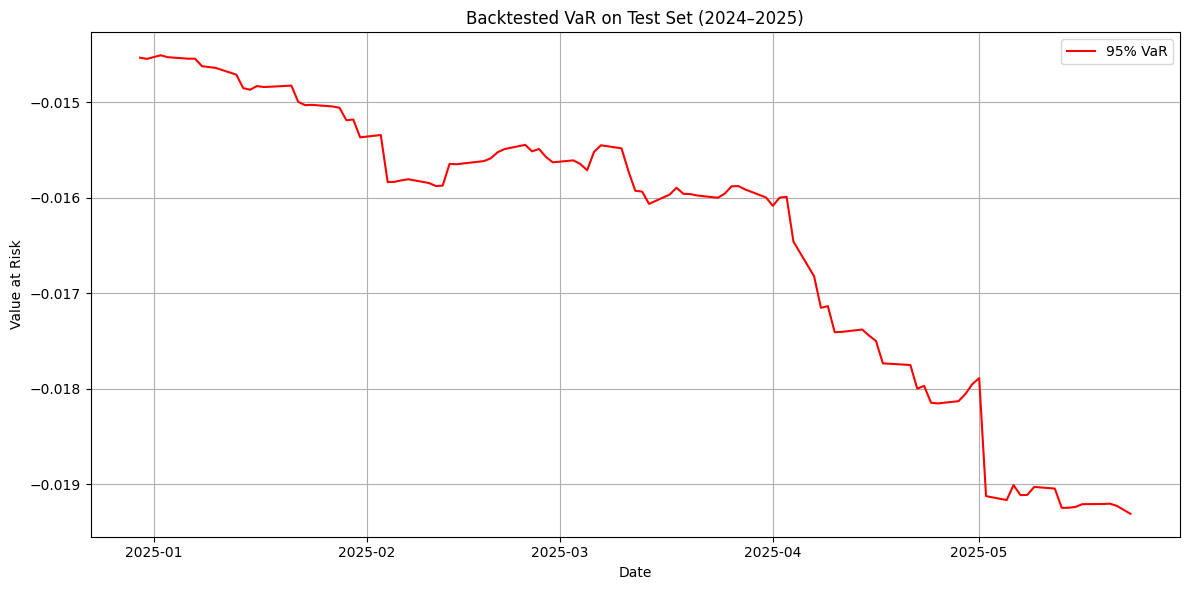

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_dates, test_VaR, label='95% VaR', color='red')
plt.title("Backtested VaR on Test Set (2024–2025)")
plt.xlabel("Date")
plt.ylabel("Value at Risk")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


4.2 Visualize VaR over the Test Period

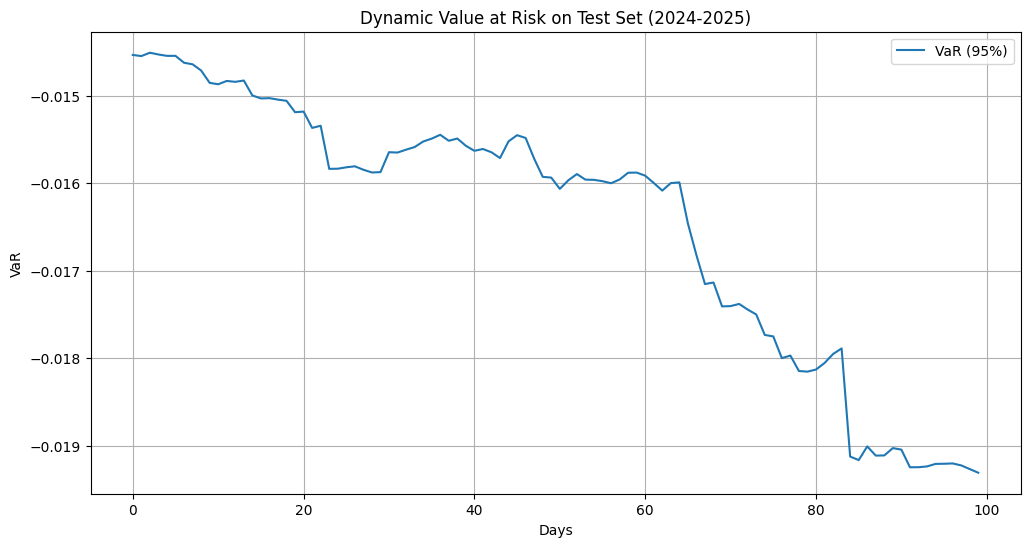

In [16]:
plt.figure(figsize=(12,6))
plt.plot(test_VaR, label='VaR (95%)')
plt.title('Dynamic Value at Risk on Test Set (2024-2025)')
plt.xlabel('Days')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.show()
